# Boston Marathon Clustering Project
Clustering data analysis on the data set of Boston Marathon 2014.
 
This project focuses on Boston Marathon 2014 data set for purpose of finding the best number of clusters in data which contain more similar data points in themselves, and also explore some important features conributions in each cluster. <br>
Boston Marathond dataset contains a veriety of information on runners and their performance, and in this project we are using PCA feature selection to identify most important components then use k-mean clustering algorithm, and calculate their silhoutte score for finding the best numbers for k. The sections included in this notebook are: Process data, Apply Models, Analyse clusters, and Conclusion.

In [1]:
# Load necessory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import  silhouette_score
import warnings
warnings.filterwarnings("ignore")

# Process Data
### Reading and Exploring the Data Set 

In [2]:
# Pick and Load Boston Morathon 2014 
df_2014 = pd.read_csv('Results/2014/results.csv')

pd.set_option('display.max_columns', None)

df_2014.info()
print('\n')
df_2014.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB




,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


### Data Visalization and Exploration

Text(0.5, 1.0, 'Participants per age & gender')

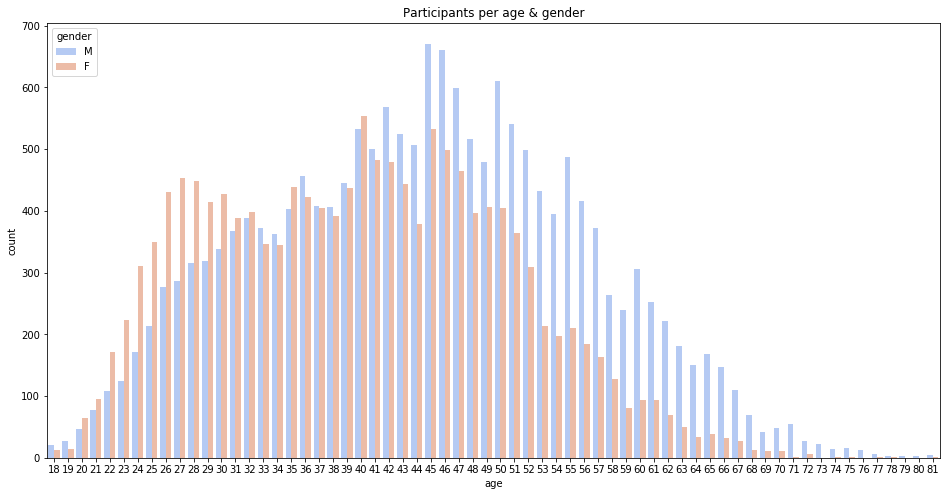

In [4]:
g = sns.countplot('age', data=df_2014, hue='gender', palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Participants per age & gender")

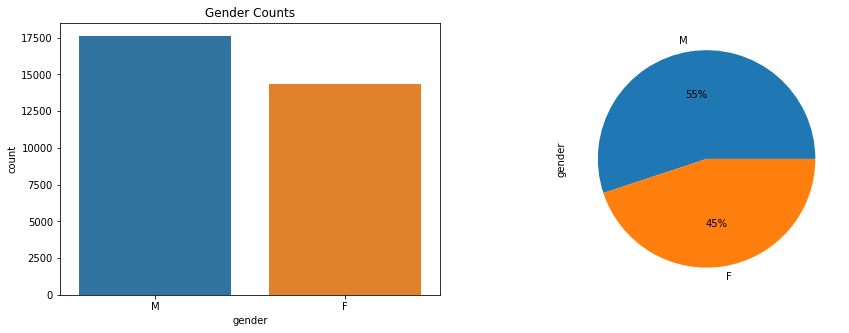

M    17617
F    14367
Name: gender, dtype: int64

In [5]:
# View runners percentage based on gender
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot('gender', data=df_2014)
plt.title('Gender Counts')
plt.subplot(1,2,2)
df_2014['gender'].value_counts().plot.pie(autopct='%1.0f%%',
                                shadow=False, startangle=0)
plt.show()
pd.value_counts(df_2014['gender'])

There are totally 31984 observations with 21 features. Except for gender, most categorical features do not contain computing information, but most numeric features contain information about runners performance wich will be effective in our clustering model. 

In [6]:
print(df_2014.dtypes)

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object


Because gender is important, we keep it and drop the rest of categorical features. We can easily convert gender to numeric values for computation purpose.  

In [3]:
# Convert male/female to 1/0 and gender column name
df_2014 = df_2014.rename(columns = {'gender':'Gender'})
df_2014['Gender'].replace(('F', 'M'), (0, 1), inplace=True)

In [4]:
# Drop categorical features
categorical = ['name', 'bib','ctz','state','country','city']
df_2014 = df_2014.drop(categorical, axis=1)

In [5]:
# Change dtypes from 'object' to 'floatt64'
cols = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']
df_2014[cols] = df_2014[cols].apply(pd.to_numeric, errors = 'coerce', axis=1)
df_2014.dtypes

10k          float64
division       int64
25k          float64
Gender         int64
age            int64
official     float64
genderdiv      int64
35k          float64
overall        int64
pace         float64
30k          float64
5k           float64
half         float64
20k          float64
40k          float64
dtype: object

### Check for missing values

In [6]:
# Calculate the percentage of missing values
df_2014.isnull().sum()/len(df_2014)*100

10k          0.156328
division     0.000000
25k          0.675338
is_male      0.000000
age          0.000000
official     0.000000
genderdiv    0.000000
35k          0.106303
overall      0.000000
pace         0.000000
30k          0.125063
5k           0.162581
half         0.225113
20k          0.159455
40k          0.121936
dtype: float64

Since in maximum less than 1% of each variable is missing, and the data set contains 31984 observations then dropping all rows that contain NaN values does not impact our analysis, and we drop them.

In [6]:
# Drop all rows that contain NaN values
numeric = ['10k', 'division', '25k', 'Gender', 'age', 'official', 'genderdiv', '35k', 'overall', 'pace', '30k', '5k', 'half',
           '20k', '40k']
df_2014 = df_2014.dropna(subset = numeric)

print(len(df_2014))

31649


# Apply Models
### Set Input Variables and 

In [7]:
# Set input
X = df_2014

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [24]:
for n in range(2,8):
    clusters = KMeans(n_clusters=n, random_state=123)
    preds = clusters.fit_predict(X_std)
    score = silhouette_score (X_std, preds, metric='euclidean')
    print ("For n_clusters = {}, silhoutte score is {}".format(n, score))

For n_clusters = 2, silhouette score is 0.4466051638573044
For n_clusters = 3, silhouette score is 0.3341333168582361
For n_clusters = 4, silhouette score is 0.2788687218734547
For n_clusters = 5, silhouette score is 0.30623221678335805
For n_clusters = 6, silhouette score is 0.31739449505677303
For n_clusters = 7, silhouette score is 0.30518927023142595


The highest silhutte score is for when k-means groups the data set in two clusters, but since the participants in the maraton are male and female, it is obvious to have the highest score for number of two clusters. The best silhouette score coud be three the second higest score after numer of two clsters. 
### Apply the clustering model with K-means using PCA featuring

In [8]:
# Fit PCA
pca = PCA(n_components=2, random_state=123)
X_pca = pca.fit_transform(X_std)
print('Shape of the new Data pca: ' + str(X_pca.shape))

Shape of the new Data pca: (31649, 2)


In [9]:
# Save pca results in a variable
X_pca_l = pd.DataFrame(X_pca, columns = ['label1','label2'])

In [25]:
for n in range(2,8):
    clusters = KMeans(n_clusters=n, random_state=123)
    preds = clusters.fit_predict(X_pca)
    score = silhouette_score (X_pca, preds, metric='euclidean')
    print ("Using PCA featuring, for n_clusters = {}, silhoutte score is {}".format(n, score))

Using PCA featuring, for n_clusters = 2, silhouette score is 0.5055978370544002
Using PCA featuring, for n_clusters = 3, silhouette score is 0.4078436764930463
Using PCA featuring, for n_clusters = 4, silhouette score is 0.3538648844323424
Using PCA featuring, for n_clusters = 5, silhouette score is 0.355416123025622
Using PCA featuring, for n_clusters = 6, silhouette score is 0.36342971678718694
Using PCA featuring, for n_clusters = 7, silhouette score is 0.3737993111198209


The results of silhuette scores with the PCA feacturing are higher, but the best number for k is still the same as before.<br>
Now that we know the best numbers for k, we can explore the observations in each cluster and some their features contributions. 

# Analyse Clusters
### Data exploration for each cluster

#### K-means: Observing the amounts of each observations in each clusters for n_clusters = 2:

In [12]:
# Fit the model
clusters = KMeans(n_clusters=2, random_state=123)
preds = clusters.fit_predict(X_pca)
X_pred = df_2014.copy()
X_pred['cluster_assignment'] = preds

X_pca_l['cluster_assignment'] = preds 

cluster_dataframes = {}
cluster_dataframes[0] = X_pred.loc[X_pred['cluster_assignment'] == 0] # First cluster
cluster_dataframes[1] = X_pred.loc[X_pred['cluster_assignment'] == 1] # Second cluster

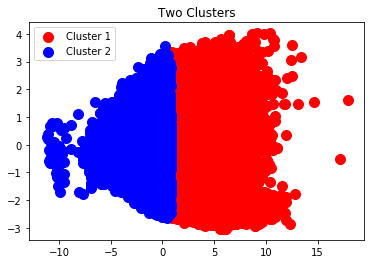

In [58]:
#Visualizing the solution of two clusters

plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 0], X_pca_l.label2[X_pca_l['cluster_assignment'] == 0], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 1], X_pca_l.label2[X_pca_l['cluster_assignment'] == 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.title('Two Clusters')
plt.legend()
plt.show()

### Gender Counts

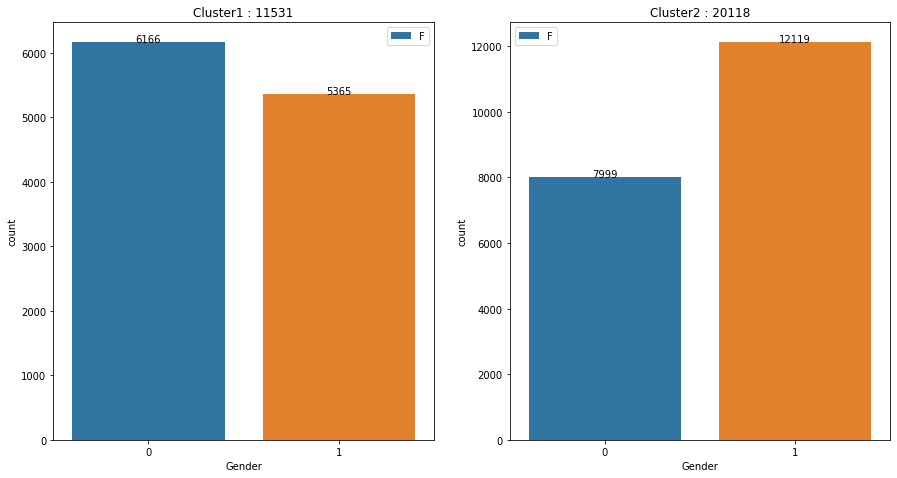

In [14]:
# Count & plot number of observations in each cluster
plt.figure(figsize=(15,2))
j=0
for i in range(0,2):
    j +=1
    plt.subplot(1,2,j)
    ax1 = sns.countplot(data=cluster_dataframes[i],x=cluster_dataframes[i]['Gender'])  
    ax1.set_title(f'Cluster{j} : {cluster_dataframes[i].Gender.count()}')    
    plt.legend('F')    
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1}'.format(height,0),
                ha="center",rotation=0)
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

For the solution of two clusters,the cluster1 contains fewer observations than cluster2. The amount of Female runners are more than Male runners in cluster1 and less in cluster2 as 53.5% observations in cluster1 and 39.8% observations in cluster2 are Female.
<br>
<br>
### Age Groups Counts
Making different ranges of age (dividing by 3 groups: 18-29, 30-49, 50-81) then Observing the amounts of each age group in each clusters

In [25]:
bins = [18, 30, 50, 82]
labels = ['18-29','30-49','50-82']
cluster_dataframes[0]['AgeGroup'] = pd.cut(cluster_dataframes[0]['age'], bins=bins, labels=labels, right=False)
cluster_dataframes[1]['AgeGroup'] = pd.cut(cluster_dataframes[1]['age'], bins=bins, labels=labels, right=False)

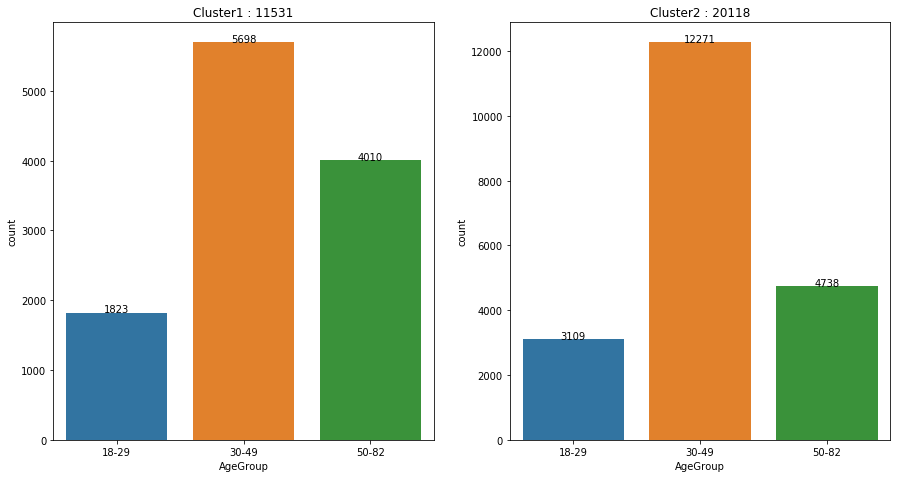

In [29]:
# Count & plot number of observations in each cluster
plt.figure(figsize=(15,2))
j=0
for i in range(0,2):
    j +=1
    plt.subplot(1,2,j)
    ax1 = sns.countplot(data=cluster_dataframes[i], x = 'AgeGroup') 
    ax1.set_title(f'Cluster{j} : {cluster_dataframes[i].AgeGroup.count()}')
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1}'.format(height,0),
                ha="center",rotation=0)
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

In both clusters the observations of second age group (30-49) are the most, and other two age groups are less repectively wit the similar pattern.  
<br>
#### K-means: Observing the amounts of observations in each clusters for n_clusters = 3:

In [30]:
# Fit the model
clusters = KMeans(n_clusters=3, random_state=123)
preds = clusters.fit_predict(X_pca)
X_pred = df_2014.copy()
X_pred['cluster_assignment'] = preds

X_pca_l['cluster_assignment'] = preds 

cluster_dataframes = {}
cluster_dataframes[0] = X_pred.loc[X_pred['cluster_assignment'] == 0] # First cluster
cluster_dataframes[1] = X_pred.loc[X_pred['cluster_assignment'] == 1] # Second cluster
cluster_dataframes[2] = X_pred.loc[X_pred['cluster_assignment'] == 2] # Third cluster

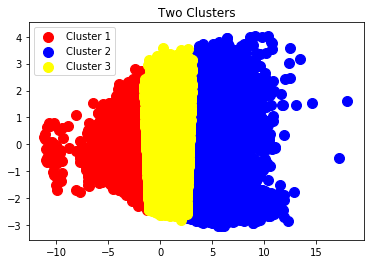

In [66]:
#Visualizing the solution of three clusters

plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 0], X_pca_l.label2[X_pca_l['cluster_assignment'] == 0], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 1], X_pca_l.label2[X_pca_l['cluster_assignment'] == 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 2], X_pca_l.label2[X_pca_l['cluster_assignment'] == 2], s = 100, c = 'yellow', label = 'Cluster 3')
plt.title('Two Clusters')
plt.legend()
plt.show()

### Gender Counts

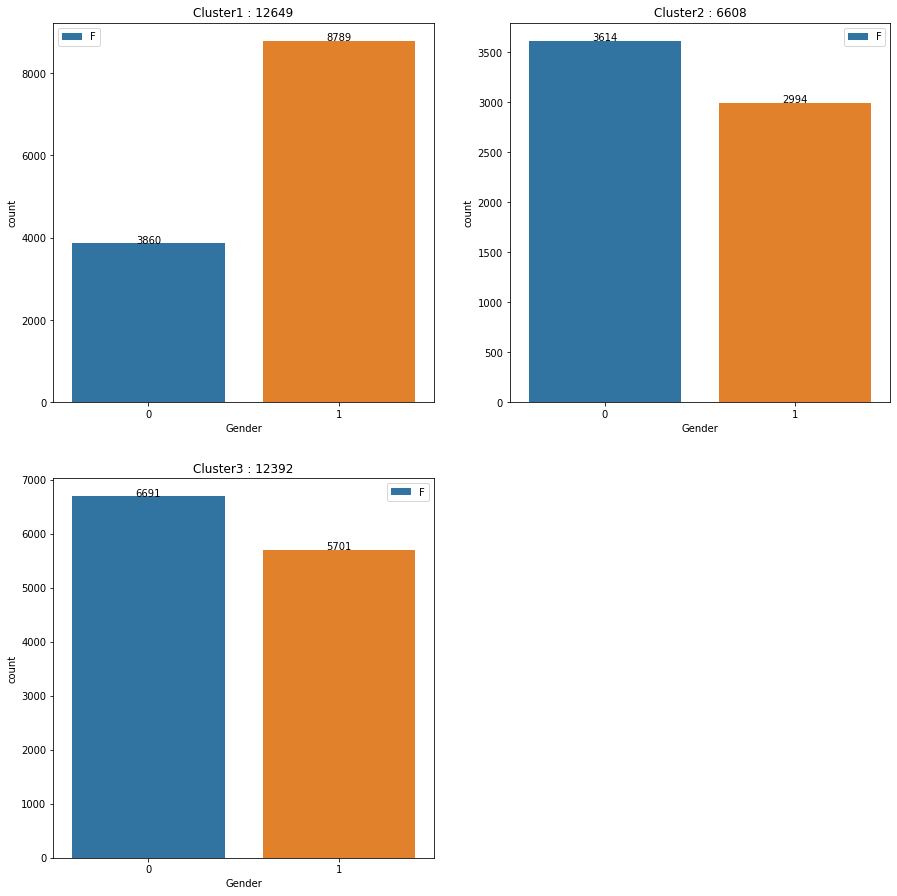

In [34]:
# Count & plot number of observations in each cluster
plt.figure(figsize=(15,4))
j=0
for i in range(0,3):
    j +=1
    plt.subplot(2,2,j)
    ax1 = sns.countplot(data=cluster_dataframes[i],x=cluster_dataframes[i]['Gender'])  
    ax1.set_title(f'Cluster{j} : {cluster_dataframes[i].Gender.count()}')    
    plt.legend('F')    
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1}'.format(height,0),
                ha="center",rotation=0)
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

For the solution of three clusters, the cluster1 and the cluster2 are almost the same size, but the size of the cluster2 is almost half of each. The amount of Female runners are 30.5% observations in cluster1, 55% observations in cluster2, and 54% observations in cluster3.<br>
<br>
### Age Groups Counts
Making different ranges of age (dividing by 3 groups: 18-29, 30-49, 50-90) then Observing the amounts of each age group in each clusters

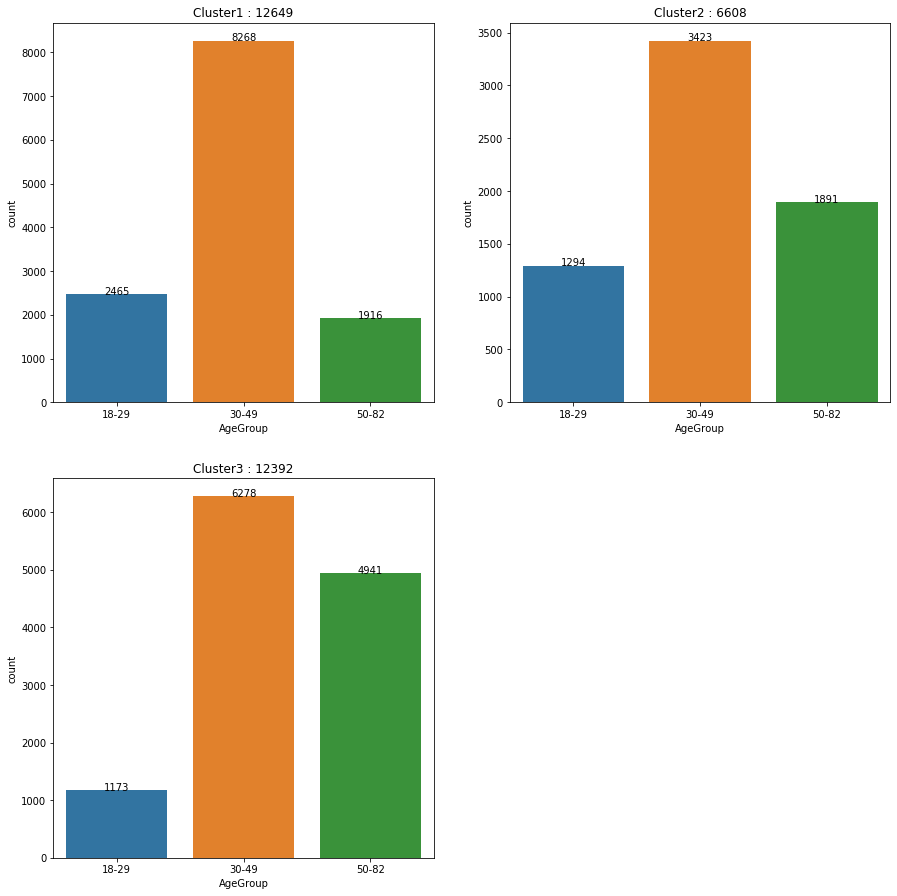

In [32]:
bins = [18, 30, 50, 82]
labels = ['18-29','30-49','50-82']
cluster_dataframes[0]['AgeGroup'] = pd.cut(cluster_dataframes[0]['age'], bins=bins, labels=labels, right=False)
cluster_dataframes[1]['AgeGroup'] = pd.cut(cluster_dataframes[1]['age'], bins=bins, labels=labels, right=False)
cluster_dataframes[2]['AgeGroup'] = pd.cut(cluster_dataframes[2]['age'], bins=bins, labels=labels, right=False)

# Count & plot number of observations in each cluster
plt.figure(figsize=(15,4))
j=0
for i in range(0,3):
    j +=1
    plt.subplot(2,2,j)
    ax1 = sns.countplot(data=cluster_dataframes[i], x = 'AgeGroup') 
    ax1.set_title(f'Cluster{j} : {cluster_dataframes[i].AgeGroup.count()}')
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1}'.format(height,0),
                ha="center",rotation=0)
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

Again the second age group observations (30-49) are the most in all three clusters. In the cluster1, the first age group amount is more than the third one and viceversa in the other two.
<br>
### Apply the clustering model with GMM using PCA featuring

In [14]:
for n in range(2,8):
    gmm_cluster = GaussianMixture(n_components=n, random_state=123)   
    preds = gmm_cluster.fit_predict(X_pca)
    score = silhouette_score (X_pca, preds, metric='euclidean')
    print ("Using PCA featuring, for n_clusters = {}, silhoutte score is {}".format(n, score))

Using PCA featuring, for n_clusters = 2, silhoutte score is 0.5024073059481151
Using PCA featuring, for n_clusters = 3, silhoutte score is 0.39929341765000087
Using PCA featuring, for n_clusters = 4, silhoutte score is 0.3490592353676033
Using PCA featuring, for n_clusters = 5, silhoutte score is 0.23188273182509472
Using PCA featuring, for n_clusters = 6, silhoutte score is 0.2578743692179249
Using PCA featuring, for n_clusters = 7, silhoutte score is 0.28210174482281747


Similar to k-means, the values of silhoutte scrores for GMM are decresing as number of cluster increasing, and the best and highest silhoutte score belongs to n=2. It is of note that silhouette score droppes a lot since n=5 respect the previous number while in k-means these values keep stay in same range repctively.
<br>
#### GMM: Observing the amounts of observations in each clusters for n_clusters = 3:

In [27]:
# Fit the model
clusters = GaussianMixture(n_components=3, random_state=123)
preds = clusters.fit_predict(X_pca)
X_pred = df_2014.copy()
X_pred['cluster_assignment'] = preds

X_pca_l['cluster_assignment'] = preds 

cluster_dataframes = {}
cluster_dataframes[0] = X_pred.loc[X_pred['cluster_assignment'] == 0] # First cluster
cluster_dataframes[1] = X_pred.loc[X_pred['cluster_assignment'] == 1] # Second cluster
cluster_dataframes[2] = X_pred.loc[X_pred['cluster_assignment'] == 2] # Third cluster

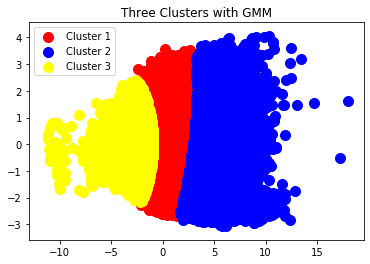

In [28]:
#Visualizing the solution of three clusters

plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 0], X_pca_l.label2[X_pca_l['cluster_assignment'] == 0], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 1], X_pca_l.label2[X_pca_l['cluster_assignment'] == 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X_pca_l.label1[X_pca_l['cluster_assignment'] == 2], X_pca_l.label2[X_pca_l['cluster_assignment'] == 2], s = 100, c = 'yellow', label = 'Cluster 3')
plt.title('Three Clusters with GMM')
plt.legend()
plt.show()

### Gender Counts

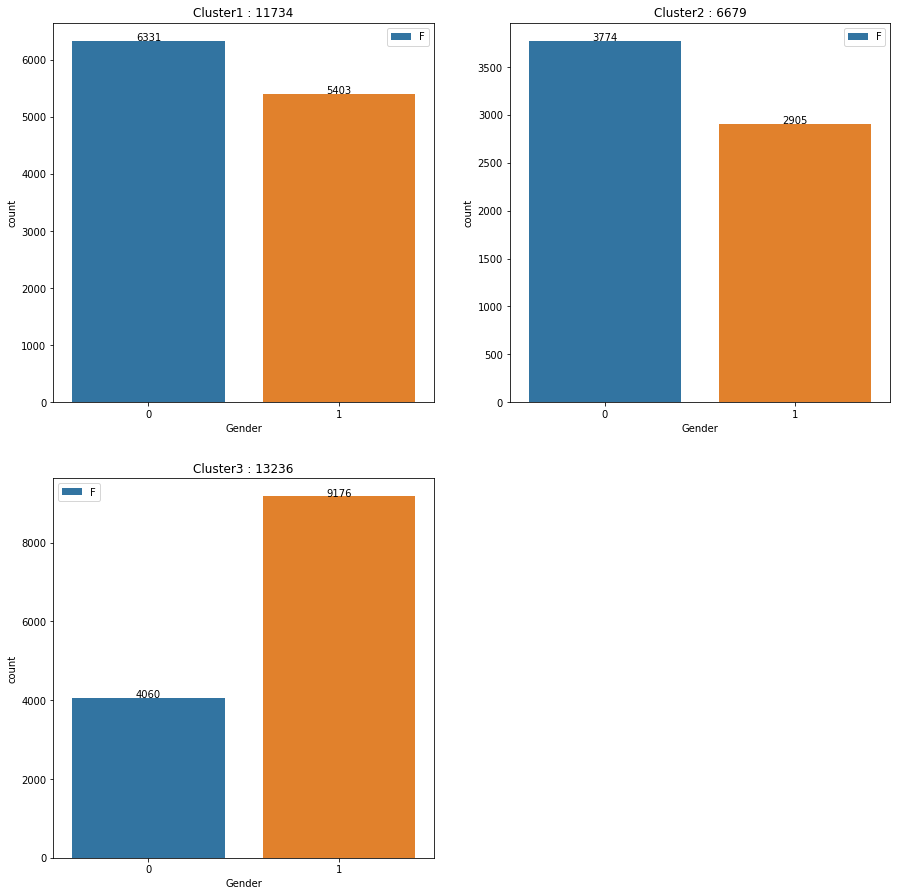

In [30]:
# Count & plot number of observations in each cluster
plt.figure(figsize=(15,4))
j=0
for i in range(0,3):
    j +=1
    plt.subplot(2,2,j)
    ax1 = sns.countplot(data=cluster_dataframes[i],x=cluster_dataframes[i]['Gender'])  
    ax1.set_title(f'Cluster{j} : {cluster_dataframes[i].Gender.count()}')    
    plt.legend('F')    
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1}'.format(height,0),
                ha="center",rotation=0)
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

Cluster1 and Cluster2 are similar as both of them contains higher amount of female observations and almost the same portion, but in Clister3 number of male observations in higher.  

## Age groups count

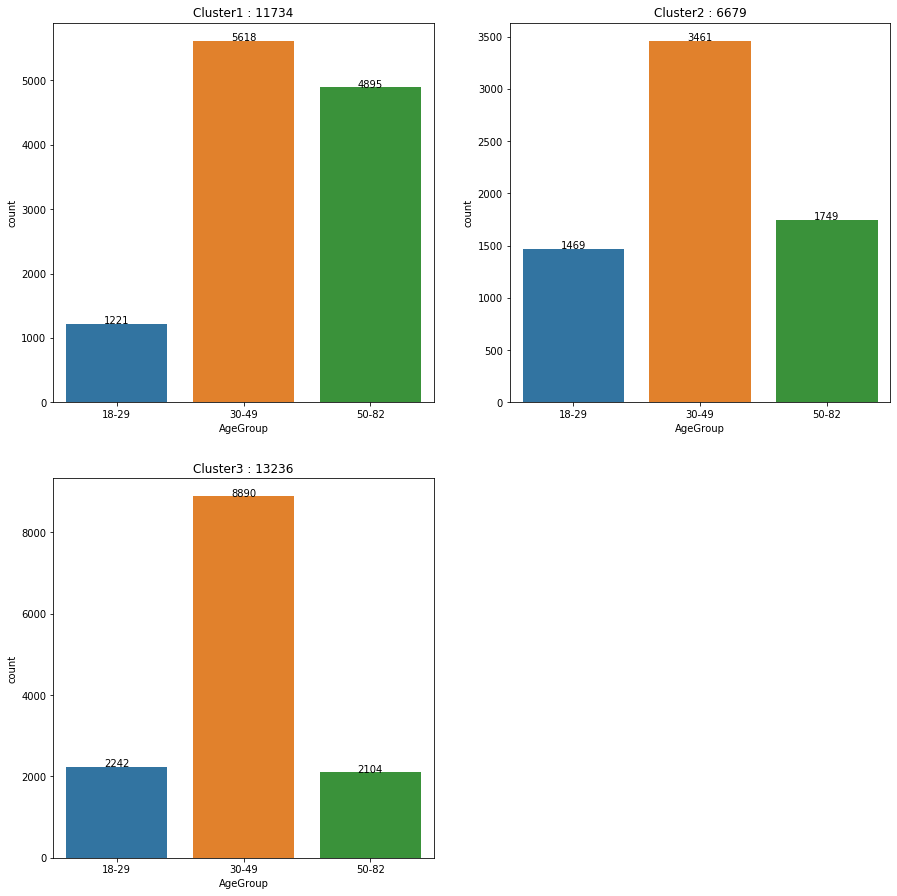

In [31]:
bins = [18, 30, 50, 82]
labels = ['18-29','30-49','50-82']
cluster_dataframes[0]['AgeGroup'] = pd.cut(cluster_dataframes[0]['age'], bins=bins, labels=labels, right=False)
cluster_dataframes[1]['AgeGroup'] = pd.cut(cluster_dataframes[1]['age'], bins=bins, labels=labels, right=False)
cluster_dataframes[2]['AgeGroup'] = pd.cut(cluster_dataframes[2]['age'], bins=bins, labels=labels, right=False)

# Count & plot number of observations in each cluster
plt.figure(figsize=(15,4))
j=0
for i in range(0,3):
    j +=1
    plt.subplot(2,2,j)
    ax1 = sns.countplot(data=cluster_dataframes[i], x = 'AgeGroup') 
    ax1.set_title(f'Cluster{j} : {cluster_dataframes[i].AgeGroup.count()}')
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1}'.format(height,0),
                ha="center",rotation=0)
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

The three cluster look similar for the age groups contribution in each cluster. The middle group(30-49) has the most contribution in all three cluster, and except for the Cluster 1, the amounts of each group are almost the same.  

# Conclusion
Models of K-means performed on this data set show us that for the best number of k resulted by the Silhoutte score, the data set cannot be clustered based on gender and age groups. All clusters contain amounts of observations of all determined categories and there are no a similar patterns in quantity of observations in each category. K-means might not be the best algorithm since the values of the Silhoutte scores are not high. That is of note other variables also contribute in the features which can be observed their shares in the clustering results.     
Similar to k-means, the silhoutte score is descendig as number of cluster increases. GMM clustering also has different distributions of observations for each group in each cluster. 